Check if you specifying the right "path" below to the google colab notebook on Drive to make sure everything below is working properly

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
path = 'gdrive/My Drive/RNNWavefunctions/RNNWavefunctions-master/1DTFIM'
sys.path.append(path)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['axes.labelsize']  = 20
rcParams['font.serif']      = ['Computer Modern']
rcParams['font.size']       = 10
rcParams['legend.fontsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

## **Calculating the ground state energy of 1DTFIM using Exact Diagonalization (ED)**

Here, we attempt to calculate the ground state and the ground state energy of the 1D Transverse field Ising Model with Open Boundary Conditions using Exact diagonalization

In [0]:
def IsingMatrixElements(Jz,Bx,sigmap):
    """
    computes the matrix element of the open Ising Hamiltonian for a given state sigmap
    -----------------------------------------------------------------------------------
    Parameters:
    Jz: np.ndarray of shape (N), respectively, and dtype=float:
                Ising parameters
    sigmap:     np.ndarrray of dtype=int and shape (N)
                spin-state, integer encoded (using 0 for down spin and 1 for up spin)
                A sample of spins can be fed here.
    Bx: Transvers magnetic field (N)
    -----------------------------------------------------------------------------------            
    Returns: 2-tuple of type (np.ndarray,np.ndarray)
             sigmas:         np.ndarray of dtype=int and shape (?,N)
                             the states for which there exist non-zero matrix elements for given sigmap
             matrixelements: np.ndarray of dtype=float and shape (?)
                             the non-zero matrix elements
    """
    #the diagonal part is simply the sum of all Sz-Sz interactions
    diag=0
    
    sigmas=[]
    matrix_elements=[]
    N = Jz.shape[0]
    
    for site in range(N-1):
        if sigmap[site]==sigmap[site+1]: #if the two neighouring spins are the same (We use open Boundary Conditions)
            diag-=Jz[site] #add a negative energy contribution (We use ferromagnetic couplings)
        else:
            diag+=Jz[site]
            
    matrix_elements.append(diag)
    sigmas.append(sigmap)
    
    #off-diagonal part (For the transverse Ising Model)
    for site in range(N):
        if Bx[site] != 0:
            sig = np.copy(sigmap)
            sig[site]=np.abs(1-sig[site])
            matrix_elements.append(-Bx[site])
            sigmas.append(sig)    

    return np.array(sigmas),np.array(matrix_elements)

def ED_1DTFIM(N=10, h = 1):
  """
  Returns a tuple (eta,U)
    eta = a list of energy eigenvalues.
    U = a list of energy eigenvectors
  """
  Jz=+np.ones(N)
  Bx=+h*np.ones(N)

  basis = []
  #Generate a z-basis
  for i in range(2**N):
      basis_temp = np.zeros((N))
      a = np.array([int(d) for d in bin(i)[2:]])
      l = len(a)
      basis_temp[N-l:] = a
      
      basis.append(basis_temp)
  basis = np.array(basis)
      
  H=np.zeros((basis.shape[0],basis.shape[0])) #prepare the hamiltonian
  for n in range(basis.shape[0]):
      sigmas,elements=IsingMatrixElements(Jz,Bx,basis[n])
      for m in range(sigmas.shape[0]):
          for b in range(basis.shape[0]):
              if np.all(basis[b,:]==sigmas[m,:]):
                  H[n,b]=elements[m]
                  break
  eta,U=np.linalg.eigh(H) #diagonalize
  return eta,U


In [4]:
eta, U = ED_1DTFIM(N=10, h = 1)

print('The ground state energy is:')
print(min(eta))
E_exact = min(eta)

The ground state energy is:
-12.38148999965476


## **Representing the ground state**

Sometimes it is useful to represent the ground state in a plot as shown below, to know some information about the properties of the ground state, such as symmetries, sign of the amplitudes,...

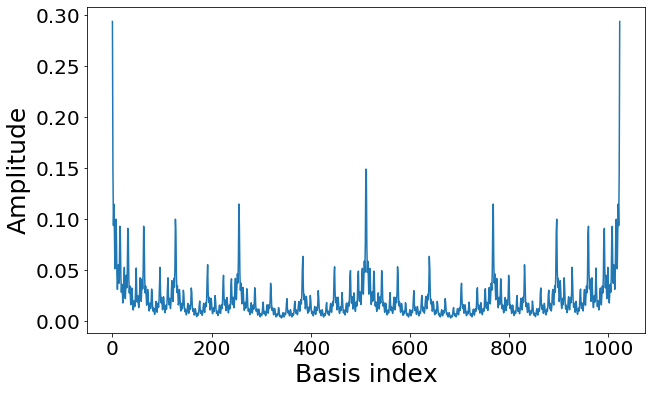

In [5]:
fig, ax = plt.subplots(figsize=(10,6))

ground_state = -U[:,np.nonzero(eta==np.min(eta))[0][0]]

plt.plot(ground_state,label="Ground state")

ax.set_xlabel(r'Basis index', fontsize = 25)
ax.set_ylabel('Amplitude', fontsize = 25)

plt.show()

We notice here that the amplitudes of the ground state in the z-basis do not change sign, hence we can use a positive recurrent neural network wavefunction (pRNN wavefunction)

## **Calculating the ground state energy using an RNN wavefunction**

After that we obtained the ground state energy from exact diagonalization, we are going to value as a reference to assess the quality of the variational energy calculated by the pRNN wavefunction

In [19]:
from TrainingRNN_1DTFIM import run_1DTFIM

#numsteps = number of training iterations
#systemsize = number of physical spins
#Bx = transverse magnetic field
#numsamples = number of samples used for training
numsamples = 200
#num_units = number of memory units of the hidden state of the RNN
#num_layers = number of vertically stacked RNN cells

#This function trains a pRNN wavefunction for 1DTFIM with the corresponding hyperparams
RNNEnergy, varRNNEnergy = run_1DTFIM(numsteps = 1000, systemsize = 10, Bx = +1, num_units = 10,  num_layers = 1, numsamples = numsamples, learningrate = 5e-3, seed = 111)

#RNNEnergy is a numpy array of the variational energy of the pRNN wavefunction
#varRNNEnergy is a numpy array of the variance of the variational energy of the pRNN wavefunction

The number of variational parameters of the pRNN wavefunction is 422


mean(E): -9.899331220975746, var(E): 9.654476094188208, #samples 200, #Step 0 


mean(E): -10.588295933094894, var(E): 6.791601049571212, #samples 200, #Step 10 


mean(E): -11.308381077623483, var(E): 3.7705650947029623, #samples 200, #Step 20 


mean(E): -11.77833035700152, var(E): 1.8443101161151372, #samples 200, #Step 30 


mean(E): -11.83521451414994, var(E): 1.0315675928581793, #samples 200, #Step 40 


mean(E): -11.855886625327708, var(E): 1.1139435449774417, #samples 200, #Step 50 


mean(E): -12.048212244109145, var(E): 0.9111520103244755, #samples 200, #Step 60 


mean(E): -12.178347486041012, var(E): 0.43777386332315715, #samples 200, #Step 70 


mean(E): -12.198066877181347, var(E): 0.23696837877114477, #samples 200, #Step 80 


mean(E): -12.27313570286033, var(E): 0.323460117948143, #samples 200, #Step 90 


mean(E): -12.266153675537653, var(E): 0.23543409187599212, #samples 200, #Step 100 


mean(E): 

## **Comparison of RNN results with ED**

After we got the variational energies for each time step, we can now compare the RNN results with exact diagonalization

In [20]:
#Computing the ground state energy by taking average over the last 100 iterations
print("Ground state energy = ", np.mean(RNNEnergy[-100:]), "+-", np.sqrt(np.max(varRNNEnergy[-100:])/(numsamples*100))) #We use np.max(varRNNEnergy[-100:]) to estimate an upper bound on the variance
print("Exact ground state energy = ", E_exact)

Ground state energy =  -12.38083759458178 +- 0.0007350316298291748
Exact ground state energy =  -12.38148999965476


We can also plot the variational energy and the energy variance where we observe convergence during the last iterations

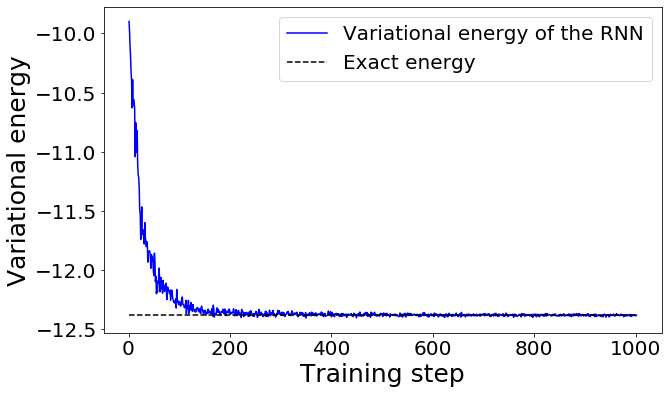

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.arange(1, len(RNNEnergy)+1), RNNEnergy, "b-", label="Variational energy of the RNN")
ax.plot(np.arange(1, len(RNNEnergy)+1), [E_exact]*len(RNNEnergy), "k--", label="Exact energy")

ax.set_xlabel(r'Training step', fontsize = 25)
ax.set_ylabel('Variational energy', fontsize = 25)
plt.legend()

plt.show()

### **Energy variance**

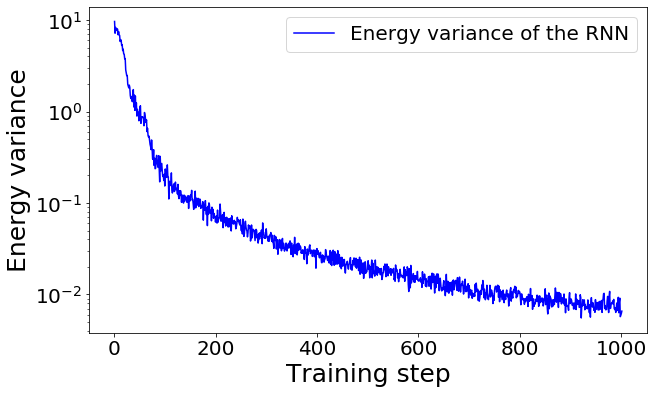

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

ax.semilogy(np.arange(1, len(RNNEnergy)+1), varRNNEnergy, "b-", label="Energy variance of the RNN")

ax.set_xlabel(r'Training step', fontsize = 25)
ax.set_ylabel('Energy variance', fontsize = 25)
plt.legend()

plt.show()

## **Explorations**

- If you want to explore large system sizes with the pRNN wavefunction, here are some ground states energy of 1DTFIM at the critical point (Bx = 1) given by DMRG and can be considered exact:


> N=20 : -25.1077971081

> N=30 : -37.8380982304

> N=40 : -50.5694337844

> N=50 : -63.3011891370

> N=60 : -76.0331561023

> N=70 : -88.7652446334

> N=80 : -101.4974094169

> N=90 : -114.2296251736

> N=100 : -126.9618766964

> N=1000 : -1272.8762945220

- You can also play with the hyperparameters (memory units, number of layers, number of samples, learning rate) to obtain better accuracies

 